
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fblaura/FraudD/blob/main/AutoML/2_AutoML_for_dataset_passed_by_Normalization_and_SMOTE_imbalance_of_0_1.ipynb)

 **Please make sure to install the following libraries in order for the entire notebook to work.**

AutoML H20 is a process that assists in the selection of training models, which compares the performance of models by comparing metrics, which are then reflected in a leaderboard. In order to get an initial idea of which supervised or unsupervised models are ideal for our case (fraud detection) this type of training is used. The data used for this exercise is coded, preprocessed and passed through a technique to adjust the unequal distribution of the classes of the dataset, this technique is called SMOTE (Synthetic Minority Over-sampling Technique), as a rate to adjust the imbalance is chosen: **0.05**. Inside the folder you will find AutoML executions for different scaling methods and SMOTE rates. 


# **1. Libraries Installation**

In [1]:
! pip install requests
! pip install tabulate
! pip install "colorama>=0.3.8"
! pip install future

In [2]:
!pip install gdown

In [3]:
! pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o


Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 175.8 MB 29 kB/s 
  Created wheel for h2o: filename=h2o-3.34.0.3-py2.py3-none-any.whl size=175832480 sha256=279d993e836e9b9e76a4d01573939a642a7f8f5be3cf0580009ed9f7b08a34b7
  Stored in directory: /root/.cache/pip/wheels/2a/52/cf/01f6938288f0731963463ff72510db67f9f3076f801038b2f7
Successfully built h2o


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Normalizer, StandardScaler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
from sklearn.feature_selection import SelectFromModel, RFECV, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [6]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

In [7]:
import pickle

In [8]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, cross_val_predict, validation_curve
from datetime import datetime
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, f1_score,plot_roc_curve, classification_report,log_loss,recall_score,adjusted_rand_score


In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, learning_curve, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, roc_curve,precision_score,roc_auc_score

# **2. Definition of different functions**

In [10]:
def roc_curve_plot(model,model_name,ytest,xtest):
  pred_prob = model.predict_proba(xtest)
  fpr, tpr, thresh = roc_curve(ytest, pred_prob[:,1], pos_label=1)
  # roc curve for tpr = fpr 
  random_probs = [0 for i in range(len(ytest))]
  p_fpr, p_tpr, _ = roc_curve(ytest, random_probs, pos_label=1)
  #plot
  plt.style.use('seaborn')
  auc=roc_auc_score(ytest, pred_prob[:,1])
  # plot roc curves
  plt.plot(fpr, tpr,linewidth=3, linestyle='--',color='orange', label="AUC="+str(auc))
  plt.plot(p_fpr, p_tpr, linewidth=3, linestyle='--', color='blue')
  # title
  plt.title('ROC curve')
  # x label
  plt.xlabel('False Positive Rate')
  # y label
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()
  return plt

In [11]:
def autolabel(rects):
    for rect in rects:
        
        width = rect.get_width()
        plt.text(1.05*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                 '%.2f' % float(width),
                 ha='center', va='center')

In [12]:
def labels(rects):
  for p in rects.patches:
    ax.annotate(np.round(p.get_height(),decimals=2),((p.get_x()-0.15)+p.get_width(), p.get_height()+2),ha='center',va='center')

# **3. h2o initialization**

In [12]:
import h2o
from h2o.automl import H2OAutoML


In [13]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmlozeryp
  JVM stdout: /tmp/tmpmlozeryp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmlozeryp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_unknownUser_9wiaur
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


# **4. Dataset initialization**

In [13]:
from google.colab import files

In [14]:
#train_fill
!gdown --id 10lD33nbEwBF7XpgQiVRfWzO2Y0pUY3nA

Downloading...
From: https://drive.google.com/uc?id=10lD33nbEwBF7XpgQiVRfWzO2Y0pUY3nA
To: /content/X_trainss_01.csv
100% 686M/686M [00:09<00:00, 74.3MB/s]


In [15]:
X_trainss_01 = pd.read_csv('/content/X_trainss_01.csv',error_bad_lines=False)

b'Skipping line 74954: expected 432 fields, saw 489\n'


In [16]:
X_trainss_01

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_35,id_36,id_37,id_38,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,CurrencyCents,CurrencyDollar,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32,MobileCompareSerial,TransactionID,TransactionDT,card1,CentsDigits,isFraud
0,0.73600,-2.438198,-1.421715,-0.341023,-0.083186,0.0,0.186352,0.281360,2.922440,-0.423689,1.640759,-0.158137,-0.265768,0.160981,0.217591,-0.457419,0.447464,0.072847,-0.003701,-0.435635,-0.446449,0.326466,-0.167966,0.292131,0.278315,-0.286590,0.041363,-0.274044,-1.448447,0.229787,0.168792,-0.124002,-0.097562,-0.137700,-0.139046,-0.103497,-0.129767,-0.201776,-0.148080,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.061457,-0.085408,-0.085009,-0.086519,0.516788,-0.287635,0.137939,-0.164430,-0.063159,0.038139,-0.207028,0.207908,0.005474,0.027114,-0.060995,0.052452,0.150306,0.216116,0.250989,-0.269621,0.186871,-0.042122,0.019665,-0.068128,-0.030527,0.071963,-0.007271,-0.008259,-0.295907,-0.266837,-1.732027,-1.756537,0.818050,-0.670784,0
1,0.73600,-0.904898,-1.421715,-0.341023,-0.083186,0.0,0.186352,0.281360,-0.411229,2.360224,1.640759,-0.158137,-0.265768,0.160981,0.217591,-0.457419,0.447464,0.072847,-0.003701,-0.435635,-0.446449,0.326466,-0.167966,0.292131,0.278315,-0.478321,0.224814,-0.274044,-2.435659,0.329704,0.168792,-0.168789,-0.097562,-0.137700,-0.139046,-0.103497,-0.129767,-0.201776,-0.148080,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.061457,-0.085408,-0.085009,-0.086519,-0.713841,-0.476956,0.137939,-0.164430,-0.063159,0.038139,-0.207028,0.207908,0.005474,0.027114,-0.060995,0.052452,0.150306,0.216116,0.250989,-0.269621,0.186871,-0.042122,0.019665,-0.068128,-0.030527,0.071963,-0.007271,-0.008259,-0.295907,-0.266837,-1.731980,-1.756535,-1.451410,-0.670784,0
2,0.73600,0.628401,0.702593,0.842275,-0.083186,0.0,0.186352,0.281360,-0.411229,-0.423689,-0.609474,-0.158137,-0.265768,-6.211912,0.217591,-0.457419,0.447464,0.072847,-0.003701,-0.435635,-0.446449,0.326466,-0.167966,0.292131,0.278315,-0.332703,0.768843,-0.274044,-0.856119,0.379663,0.168792,1.076299,-0.097562,-0.137700,-0.139046,-0.103497,-0.129767,-0.201776,-0.148080,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.061457,-0.085408,-0.085009,-0.086519,-0.713841,-0.331325,0.137939,-0.164430,-0.063159,0.038139,-0.207028,0.207908,0.005474,0.027114,-0.060995,0.052452,0.150306,0.216116,0.250989,-0.269621,0.186871,-0.042122,0.019665,-0.068128,-0.030527,0.071963,-0.007271,-0.008259,-0.295907,-0.266837,-1.731932,-1.756384,-1.063787,-0.670784,0
3,0.73600,-0.904898,0.702593,1.963293,-0.083186,0.0,0.186352,0.281360,-0.411229,2.360224,-0.609474,-0.158137,-0.265768,0.160981,0.217591,-0.457419,0.447464,0.072847,-0.003701,-0.435635,-0.446449,0.326466,-0.167966,0.292131,0.278315,-0.376388,1.255938,-0.274044,-2.065454,1.838456,0.168792,-0.168789,-0.097562,-0.134878,-0.129379,-0.103497,-0.129767,-0.201776,-0.131187,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.061457,-0.085408,-0.085009,-0.086519,-0.713841,-0.375014,0.137939,-0.164430,-0.063159,0.038139,-0.207028,0.207908,0.005474,0.027114,-0.060995,0.052452,0.150306,0.216116,0.250989,-0.269621,0.186871,-0.042122,0.019665,-0.068128,-0.030527,0.071963,-0.007271,-0.008259,-0.295907,-0.266837,-1.731885,-1.756318,1.672526,-0.670784,0
4,-1.25103,-0.904898,-1.421715,-0.341023,-0.083186,0.0,0.186352,0.281360,-0.411229,-0.423689,-0.609474,-0.158137,-0.265768,0.160981,0.217591,1.747812,0.447464,0.072847,-0.003701,2.295501,2.239898,0.326466,-0.167966,0.292131,0.278315,-0.376388,0.920665,-0.274044,-2.435659,1.278919,0.168792,-0.168789,-0.097562,-0.137700,-0.139046,-0.103497,-0.129767,-0.201776,-0.148080,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.

In [17]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [18]:
Y = X_trainss_01['isFraud']
X = X_trainss_01.drop(['isFraud', 'TransactionID'], axis=1)

In [19]:
target_n=pd.unique(Y)
target_n

array([0, 1])

# **5. AutoML for dataset with StandardScaler scaling and imbalance with SMOTE 0.1**

The training process with AutoML is then initiated, the task is defined as a classification problem. The conversion from Pandas Dataframe to H2O dataframe is made in order to start the automatic process; the leaderboard and the best models are called. 

Different notebooks are created due to the RAM consumption generated by the conversion from Pandas to H20 driven by the volume of the dataset. Recall also that the original Kaggle competition dataset has approximately 590.000 rows, while this notebook works with a partition representing one eighth of the data. 

In [21]:
hftrainss_01 = h2o.H2OFrame(X_trainss_01)
#hftest =h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [22]:
trainss_01, testss_01 = hftrainss_01.split_frame(ratios=[.7]) #mirar en diferentes proporciones 70/30 ... 

In [23]:
xss_01 = trainss_01.columns
yss_01 = "isFraud"
xss_01.remove(yss_01)

In [24]:
trainss_01[yss_01] = trainss_01[yss_01].asfactor()


In [25]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_runtime_secs = 3600*4, max_models=20, seed=1, exclude_algos = ["DeepLearning"]) # tres horas, ir modificando el tiempo, trabajar con 10 modelos 
# ir mirando si se necesita aumentar más modelos
aml.train(x=xss_01, y=yss_01, training_frame=trainss_01)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_3_AutoML_1_20211011_145301,0.989535,0.0428911,0.966261,0.052142,0.10011,0.010022
StackedEnsemble_BestOfFamily_2_AutoML_1_20211011_145301,0.989528,0.0428775,0.966239,0.0520602,0.100095,0.010019
StackedEnsemble_AllModels_3_AutoML_1_20211011_145301,0.989526,0.0428179,0.966304,0.051407,0.0999904,0.00999807
StackedEnsemble_AllModels_2_AutoML_1_20211011_145301,0.989523,0.0428063,0.96632,0.0518865,0.100017,0.0100035
StackedEnsemble_AllModels_1_AutoML_1_20211011_145301,0.989489,0.0428104,0.966295,0.052887,0.0999808,0.00999616
StackedEnsemble_BestOfFamily_1_AutoML_1_20211011_145301,0.9893,0.0430201,0.966,0.0523673,0.100096,0.0100192
GBM_1_AutoML_1_20211011_145301,0.989218,0.046755,0.965727,0.0546842,0.105373,0.0111034
XGBoost_1_AutoML_1_20211011_145301,0.983058,0.0567941,0.949122,0.0680678,0.114781,0.0131748
XGBoost_2_AutoML_1_20211011_145301,0.982904,0.0570394,0.948893,0.0704377,0.115398,0.0133167
XGBoost_grid_1_AutoML_1_20211011_145301_model_1,0.976559,0.0773785,0.926356,0.0841079,0.135929,0.0184767


In [27]:
lb = h2o.automl.get_leaderboard(aml, extra_columns = 'ALL')
lb


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_BestOfFamily_3_AutoML_1_20211011_145301,0.989535,0.0428911,0.966261,0.052142,0.10011,0.010022,14419,0.126623,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20211011_145301,0.989528,0.0428775,0.966239,0.0520602,0.100095,0.010019,16187,0.109897,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20211011_145301,0.989526,0.0428179,0.966304,0.051407,0.0999904,0.00999807,12308,0.141965,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20211011_145301,0.989523,0.0428063,0.96632,0.0518865,0.100017,0.0100035,13662,0.181236,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20211011_145301,0.989489,0.0428104,0.966295,0.052887,0.0999808,0.00999616,14150,0.131216,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20211011_145301,0.9893,0.0430201,0.966,0.0523673,0.100096,0.0100192,13700,0.088951,StackedEnsemble
GBM_1_AutoML_1_20211011_145301,0.989218,0.046755,0.965727,0.0546842,0.105373,0.0111034,871200,0.105277,GBM
XGBoost_1_AutoML_1_20211011_145301,0.983058,0.0567941,0.949122,0.0680678,0.114781,0.0131748,208863,0.027826,XGBoost
XGBoost_2_AutoML_1_20211011_145301,0.982904,0.0570394,0.948893,0.0704377,0.115398,0.0133167,109600,0.015713,XGBoost
XGBoost_grid_1_AutoML_1_20211011_145301_model_1,0.976559,0.0773785,0.926356,0.0841079,0.135929,0.0184767,31875,0.011139,XGBoost


And as well we can obtain information about the leader model

In [28]:
# Get the best model using the metric
m = aml.leader
m

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_3_AutoML_1_20211011_145301

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0007412658029191464
RMSE: 0.02722619699699439
LogLoss: 0.007246990212559702
Null degrees of freedom: 9928
Residual degrees of freedom: 9924
Null deviance: 5903.095908009493
Residual deviance: 143.91073164101056
AIC: 153.91073164101056
AUC: 0.9999949299817809
AUCPR: 0.9999479725804139
Gini: 0.9999898599635617

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4505945002582175: 


,,0,1,Error,Rate
0,0,9057.0,1.0,0.0001,(1.0/9058.0)
1,1,4.0,867.0,0.0046,(4.0/871.0)
2,Total,9061.0,868.0,0.0005,(5.0/9929.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.450595,0.997125,122.0
1,max f2,0.239680,0.997017,127.0
2,max f0point5,0.582431,0.998847,120.0
3,max accuracy,0.582431,0.999496,120.0
4,max precision,0.999990,1.000000,0.0
5,max recall,0.183840,1.000000,139.0
6,max specificity,0.999990,1.000000,0.0
7,max absolute_mcc,0.450595,0.996851,122.0
8,max min_per_class_accuracy,0.187277,0.998234,138.0
9,max mean_per_class_accuracy,0.183840,0.999117,139.0



Gains/Lift Table: Avg response rate:  8.77 %, avg score:  9.13 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010072,0.999991,11.399541,11.399541,1.000000,0.999997,1.000000,0.999997,0.114811,0.114811,1039.954076,1039.954076,0.114811
1,2,0.020042,0.999958,11.399541,11.399541,1.000000,0.999976,1.000000,0.999987,0.113662,0.228473,1039.954076,1039.954076,0.228473
2,3,0.030013,0.999879,11.399541,11.399541,1.000000,0.999928,1.000000,0.999967,0.113662,0.342135,1039.954076,1039.954076,0.342135
3,4,0.040085,0.999688,11.399541,11.399541,1.000000,0.999791,1.000000,0.999923,0.114811,0.456946,1039.954076,1039.954076,0.456946
4,5,0.050055,0.999092,11.399541,11.399541,1.000000,0.999447,1.000000,0.999828,0.113662,0.570608,1039.954076,1039.954076,0.570608
5,6,0.100010,0.065853,8.595621,9.998993,0.754032,0.753200,0.877140,0.876638,0.429392,1.000000,759.562146,899.899295,0.986531
6,7,0.150065,0.017219,0.000000,6.663758,0.000000,0.030958,0.584564,0.594556,0.000000,1.000000,-100.000000,566.375839,0.931663
7,8,0.200020,0.009538,0.000000,4.999496,0.000000,0.012701,0.438570,0.449238,0.000000,1.000000,-100.000000,399.949648,0.876904
8,9,0.300030,0.004304,0.000000,3.332998,0.000000,0.006333,0.292380,0.301603,0.000000,1.000000,-100.000000,233.299765,0.767278
9,10,0.400040,0.002531,0.000000,2.499748,0.000000,0.003308,0.219285,0.227029,0.000000,1.000000,-100.000000,149.974824,0.657651




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.010021961584850305
RMSE: 0.10010974770146164
LogLoss: 0.04289109712762681
Null degrees of freedom: 54587
Residual degrees of freedom: 54583
Null deviance: 32994.22645377398
Residual deviance: 4682.678420005785
AIC: 4692.678420005785
AUC: 0.9895349830873713
AUCPR: 0.9662612323263632
Gini: 0.9790699661747426

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45050347029737514: 


,,0,1,Error,Rate
0,0,49536.0,147.0,0.003,(147.0/49683.0)
1,1,497.0,4408.0,0.1013,(497.0/4905.0)
2,Total,50033.0,4555.0,0.0118,(644.0/54588.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.450503,0.931924,157.0
1,max f2,0.209650,0.920914,220.0
2,max f0point5,0.701022,0.960628,104.0
3,max accuracy,0.460275,0.988203,155.0
4,max precision,0.999944,1.000000,0.0
5,max recall,0.000187,1.000000,398.0
6,max specificity,0.999944,1.000000,0.0
7,max absolute_mcc,0.450503,0.926235,157.0
8,max min_per_class_accuracy,0.053467,0.959362,301.0
9,max mean_per_class_accuracy,0.074304,0.962187,284.0



Gains/Lift Table: Avg response rate:  8.99 %, avg score:  8.98 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.999982,11.129052,11.129052,1.000000,0.999993,1.000000,0.999993,0.111315,0.111315,1012.905199,1012.905199,0.111315
1,2,0.020004,0.999920,11.129052,11.129052,1.000000,0.999957,1.000000,0.999975,0.111315,0.222630,1012.905199,1012.905199,0.222630
2,3,0.030007,0.999736,11.129052,11.129052,1.000000,0.999842,1.000000,0.999931,0.111315,0.333945,1012.905199,1012.905199,0.333945
3,4,0.040009,0.999218,11.129052,11.129052,1.000000,0.999511,1.000000,0.999826,0.111315,0.445260,1012.905199,1012.905199,0.445260
4,5,0.050011,0.997708,11.129052,11.129052,1.000000,0.998610,1.000000,0.999583,0.111315,0.556575,1012.905199,1012.905199,0.556575
5,6,0.100004,0.124559,7.646381,9.388035,0.687065,0.678959,0.843561,0.839300,0.382263,0.938838,664.638053,838.803525,0.921649
6,7,0.150015,0.029602,0.595180,6.456726,0.053480,0.058091,0.580169,0.578865,0.029766,0.968603,-40.481993,545.672561,0.899405
7,8,0.200007,0.014498,0.154967,4.881574,0.013925,0.020672,0.438633,0.439342,0.007747,0.976351,-84.503335,388.157446,0.852989
8,9,0.300011,0.005947,0.089701,3.284283,0.008060,0.009284,0.295109,0.295990,0.008970,0.985321,-91.029890,228.428334,0.752968
9,10,0.399996,0.003205,0.053015,2.476577,0.004764,0.004388,0.222533,0.223099,0.005301,0.990622,-94.698509,147.657722,0.648936


And for other models that may be of interest to us

In [29]:
# Get the best XGBoost model using default sort metric
xgb = aml.get_best_model(algorithm="xgboost")
xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_1_20211011_145301


Model Summary: 


,,number_of_trees
0,,136.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.003193154924692743
RMSE: 0.0565080076156711
LogLoss: 0.016038839199996133
Mean Per-Class Error: 0.005610740289151872
AUC: 0.9997776791709592
AUCPR: 0.9984110121347484
Gini: 0.9995553583419183

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2633461058139801: 


,,0,1,Error,Rate
0,0,49645.0,38.0,0.0008,(38.0/49683.0)
1,1,71.0,4834.0,0.0145,(71.0/4905.0)
2,Total,49716.0,4872.0,0.002,(109.0/54588.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.263346,0.988851,220.0
1,max f2,0.239700,0.987435,225.0
2,max f0point5,0.346700,0.993246,204.0
3,max accuracy,0.263346,0.998003,220.0
4,max precision,0.999943,1.000000,0.0
5,max recall,0.010289,1.000000,360.0
6,max specificity,0.999943,1.000000,0.0
7,max absolute_mcc,0.263346,0.987762,220.0
8,max min_per_class_accuracy,0.128652,0.994292,258.0
9,max mean_per_class_accuracy,0.150613,0.994389,250.0



Gains/Lift Table: Avg response rate:  8.99 %, avg score:  8.98 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.999892,11.129052,11.129052,1.000000,0.999960,1.000000,0.999960,0.111315,0.111315,1012.905199,1012.905199,0.111315
1,2,0.020004,0.999514,11.129052,11.129052,1.000000,0.999740,1.000000,0.999850,0.111315,0.222630,1012.905199,1012.905199,0.222630
2,3,0.030007,0.998634,11.129052,11.129052,1.000000,0.999127,1.000000,0.999609,0.111315,0.333945,1012.905199,1012.905199,0.333945
3,4,0.040009,0.996556,11.129052,11.129052,1.000000,0.997707,1.000000,0.999134,0.111315,0.445260,1012.905199,1012.905199,0.445260
4,5,0.050011,0.992069,11.129052,11.129052,1.000000,0.994630,1.000000,0.998233,0.111315,0.556575,1012.905199,1012.905199,0.556575
5,6,0.100004,0.088707,8.792318,9.960899,0.790033,0.703340,0.895036,0.850814,0.439551,0.996126,779.231810,896.089907,0.984593
6,7,0.150015,0.023735,0.061149,6.660579,0.005495,0.042906,0.598486,0.581478,0.003058,0.999185,-93.885136,566.057929,0.933005
7,8,0.200007,0.012374,0.012234,4.998797,0.001099,0.017068,0.449167,0.440401,0.000612,0.999796,-98.776579,399.879749,0.878749
8,9,0.300011,0.005380,0.002039,3.333211,0.000183,0.008141,0.299505,0.296314,0.000204,1.000000,-99.796134,233.321121,0.769096
9,10,0.399996,0.002886,0.000000,2.500023,0.000000,0.003982,0.224639,0.223241,0.000000,1.000000,-100.000000,150.002290,0.659240




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.013174756519337158
RMSE: 0.11478134220916376
LogLoss: 0.05679409780288033
Mean Per-Class Error: 0.05030967896094274
AUC: 0.9830579164461299
AUCPR: 0.949121732658105
Gini: 0.9661158328922599

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37115750312805174: 


,,0,1,Error,Rate
0,0,49483.0,200.0,0.004,(200.0/49683.0)
1,1,648.0,4257.0,0.1321,(648.0/4905.0)
2,Total,50131.0,4457.0,0.0155,(848.0/54588.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.371158,0.909421,188.0
1,max f2,0.167355,0.900841,247.0
2,max f0point5,0.548531,0.948724,148.0
3,max accuracy,0.497462,0.984557,160.0
4,max precision,0.999896,1.000000,0.0
5,max recall,0.000064,1.000000,399.0
6,max specificity,0.999896,1.000000,0.0
7,max absolute_mcc,0.497462,0.902318,160.0
8,max min_per_class_accuracy,0.039468,0.944343,322.0
9,max mean_per_class_accuracy,0.078111,0.949690,293.0



Gains/Lift Table: Avg response rate:  8.99 %, avg score:  8.51 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,9.998470e-01,11.129052,11.129052,1.000000,0.999941,1.000000,0.999941,0.111315,0.111315,1012.905199,1012.905199,0.111315
1,2,0.020004,9.993351e-01,11.129052,11.129052,1.000000,0.999636,1.000000,0.999788,0.111315,0.222630,1012.905199,1012.905199,0.222630
2,3,0.030007,9.979607e-01,11.129052,11.129052,1.000000,0.998706,1.000000,0.999427,0.111315,0.333945,1012.905199,1012.905199,0.333945
3,4,0.040009,9.940388e-01,11.129052,11.129052,1.000000,0.996380,1.000000,0.998665,0.111315,0.445260,1012.905199,1012.905199,0.445260
4,5,0.050011,9.842819e-01,11.088286,11.120899,0.996337,0.989885,0.999267,0.996909,0.110907,0.556167,1008.828623,1012.089884,0.556127
5,6,0.100004,1.095111e-01,7.214105,9.167860,0.648223,0.588048,0.823777,0.792516,0.360652,0.916820,621.410515,816.785983,0.897457
6,7,0.150015,2.960847e-02,0.640022,6.324900,0.057509,0.054813,0.568323,0.546585,0.032008,0.948828,-35.997760,532.490023,0.877677
7,8,0.200007,1.522688e-02,0.277309,4.813279,0.024918,0.020932,0.432497,0.415196,0.013863,0.962691,-72.269127,381.327931,0.837980
8,9,0.300011,6.360542e-03,0.132513,3.253024,0.011907,0.009865,0.292300,0.280085,0.013252,0.975943,-86.748702,225.302387,0.742664
9,10,0.399996,3.321506e-03,0.077483,2.459248,0.006962,0.004620,0.220975,0.211229,0.007747,0.983690,-92.251668,145.924781,0.641319




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.984869,0.002214,0.983147,0.986078,0.982048,0.987451,0.985619
1,auc,0.983107,0.004449,0.977661,0.982146,0.980587,0.988669,0.986471
2,err,0.015131,0.002214,0.016853,0.013922,0.017952,0.012549,0.014381
3,err_count,165.200000,24.180570,184.000000,152.000000,196.000000,137.000000,157.000000
4,f0point5,0.938717,0.014648,0.932514,0.952603,0.918728,0.953579,0.936161
5,f1,0.912111,0.009883,0.903866,0.914798,0.900204,0.924100,0.917585
6,f2,0.887068,0.010289,0.876926,0.879879,0.882412,0.896389,0.899732
7,lift_top_group,11.137656,0.346293,10.852882,11.480547,10.756650,11.503688,11.094512
8,logloss,0.056794,0.008453,0.066615,0.056338,0.063257,0.045554,0.052205
9,max_per_class_error,0.128830,0.012744,0.140159,0.141956,0.129064,0.121180,0.111789



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-11 15:08:35,15 min 33.856 sec,0.0,0.500000,0.693147,0.500000,0.089855,1.000000,0.910145
1,,2021-10-11 15:08:45,15 min 43.596 sec,5.0,0.193985,0.186063,0.965305,0.883138,11.129052,0.029622
2,,2021-10-11 15:08:53,15 min 51.278 sec,10.0,0.145568,0.099935,0.981366,0.929934,11.129052,0.021708
3,,2021-10-11 15:09:00,15 min 58.594 sec,15.0,0.125532,0.070276,0.988224,0.953385,11.129052,0.016231
4,,2021-10-11 15:09:08,16 min 6.386 sec,20.0,0.114838,0.057694,0.991169,0.964084,11.129052,0.013758
5,,2021-10-11 15:09:16,16 min 14.292 sec,25.0,0.107385,0.050723,0.992800,0.970780,11.129052,0.011962
6,,2021-10-11 15:09:24,16 min 22.344 sec,30.0,0.102093,0.046149,0.993979,0.975095,11.129052,0.010625
7,,2021-10-11 15:09:32,16 min 30.198 sec,35.0,0.097290,0.042018,0.995154,0.978823,11.129052,0.009709
8,,2021-10-11 15:09:40,16 min 38.331 sec,40.0,0.093709,0.038912,0.995738,0.981261,11.129052,0.008830
9,,2021-10-11 15:09:48,16 min 46.231 sec,45.0,0.090426,0.036405,0.996352,0.983612,11.129052,0.008262



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,card6,2160.837891,1.000000,0.056943
1,C14,2050.794434,0.949074,0.054043
2,V294,1669.395386,0.772569,0.043992
3,C13,1248.491333,0.577781,0.032900
4,V188,1237.796875,0.572832,0.032619
5,card1,1144.924561,0.529852,0.030171
6,card2,1024.105347,0.473939,0.026987
7,C12,944.412720,0.437059,0.024887
8,C11,872.527161,0.403791,0.022993
9,TransactionAmt,870.893066,0.403035,0.022950



See the whole table with table.as_data_frame()


We can also generate a printout of the specific parameters of a certain model. Based on this information we can define some arguments of our classification model, in this case, with supervised classification methods. 

In [30]:
xgradboost=xgb.params.keys()
for keys in xgradboost:
  print(keys,xgb.params[keys])



model_id {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'XGBoost_1_AutoML_1_20211011_145301', 'type': 'Key<Model>', 'URL': '/3/Models/XGBoost_1_AutoML_1_20211011_145301'}, 'input': None}
training_frame {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211011_145301_training_py_4_sid_adf7', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211011_145301_training_py_4_sid_adf7'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211011_145301_training_py_4_sid_adf7', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211011_145301_training_py_4_sid_adf7'}}
validation_frame {'default': None, 'actual': None, 'input': None}
nfolds {'default': 0, 'actual': 5, 'input': 5}
keep_cross_validation_models {'default': True, 'actual': False, 'input': False}
kee

In [31]:
gbm = aml.get_best_model(algorithm="GBM")
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_1_20211011_145301


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,208.0,208.0,364519.0,15.0,15.0,15.0,34.0,245.0,133.97597




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0008520056979924529
RMSE: 0.029189136643492094
LogLoss: 0.007071350494489038
Mean Per-Class Error: 0.0002515951130165339
AUC: 0.9999997250662985
AUCPR: 0.9999972240618941
Gini: 0.9999994501325971

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2740064837338943: 


,,0,1,Error,Rate
0,0,49682.0,1.0,0.0,(1.0/49683.0)
1,1,5.0,4900.0,0.001,(5.0/4905.0)
2,Total,49687.0,4901.0,0.0001,(6.0/54588.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.274006,0.999388,232.0
1,max f2,0.192892,0.999470,236.0
2,max f0point5,0.274006,0.999633,232.0
3,max accuracy,0.274006,0.999890,232.0
4,max precision,0.999874,1.000000,0.0
5,max recall,0.126207,1.000000,247.0
6,max specificity,0.999874,1.000000,0.0
7,max absolute_mcc,0.274006,0.999328,232.0
8,max min_per_class_accuracy,0.192892,0.999592,236.0
9,max mean_per_class_accuracy,0.126207,0.999748,247.0



Gains/Lift Table: Avg response rate:  8.99 %, avg score:  8.98 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.999778,11.129052,11.129052,1.000000,0.999902,1.000000,0.999902,0.111315,0.111315,1012.905199,1012.905199,0.111315
1,2,0.020004,0.999363,11.129052,11.129052,1.000000,0.999589,1.000000,0.999745,0.111315,0.222630,1012.905199,1012.905199,0.222630
2,3,0.030007,0.998607,11.129052,11.129052,1.000000,0.999015,1.000000,0.999502,0.111315,0.333945,1012.905199,1012.905199,0.333945
3,4,0.040009,0.997293,11.129052,11.129052,1.000000,0.997989,1.000000,0.999124,0.111315,0.445260,1012.905199,1012.905199,0.445260
4,5,0.050011,0.994085,11.129052,11.129052,1.000000,0.995868,1.000000,0.998472,0.111315,0.556575,1012.905199,1012.905199,0.556575
5,6,0.100004,0.038143,8.869801,9.999634,0.796995,0.745928,0.898516,0.872223,0.443425,1.000000,786.980142,899.963363,0.988849
6,7,0.150015,0.011419,0.000000,6.666015,0.000000,0.019376,0.598974,0.587906,0.000000,1.000000,-100.000000,566.601539,0.933901
7,8,0.200007,0.006451,0.000000,4.999817,0.000000,0.008506,0.449258,0.443083,0.000000,1.000000,-100.000000,399.981682,0.878973
8,9,0.300011,0.003239,0.000000,3.333211,0.000000,0.004522,0.299505,0.296896,0.000000,1.000000,-100.000000,233.321121,0.769096
9,10,0.399996,0.001969,0.000000,2.500023,0.000000,0.002531,0.224639,0.223315,0.000000,1.000000,-100.000000,150.002290,0.659240




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.011103409416863767
RMSE: 0.1053727166626341
LogLoss: 0.04675503020837522
Mean Per-Class Error: 0.03838177470237758
AUC: 0.9892184502754601
AUCPR: 0.9657268098435609
Gini: 0.9784369005509201

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2816146865224558: 


,,0,1,Error,Rate
0,0,49567.0,116.0,0.0023,(116.0/49683.0)
1,1,525.0,4380.0,0.107,(525.0/4905.0)
2,Total,50092.0,4496.0,0.0117,(641.0/54588.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.281615,0.931816,213.0
1,max f2,0.125633,0.920147,265.0
2,max f0point5,0.433893,0.960908,183.0
3,max accuracy,0.281615,0.988257,213.0
4,max precision,0.999854,1.000000,0.0
5,max recall,0.000129,1.000000,399.0
6,max specificity,0.999854,1.000000,0.0
7,max absolute_mcc,0.281615,0.926455,213.0
8,max min_per_class_accuracy,0.029605,0.958296,327.0
9,max mean_per_class_accuracy,0.043642,0.961618,312.0



Gains/Lift Table: Avg response rate:  8.99 %, avg score:  8.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.999751,11.129052,11.129052,1.000000,0.999892,1.000000,0.999892,0.111315,0.111315,1012.905199,1012.905199,0.111315
1,2,0.020004,0.999131,11.129052,11.129052,1.000000,0.999487,1.000000,0.999690,0.111315,0.222630,1012.905199,1012.905199,0.222630
2,3,0.030007,0.997755,11.129052,11.129052,1.000000,0.998516,1.000000,0.999299,0.111315,0.333945,1012.905199,1012.905199,0.333945
3,4,0.040009,0.994821,11.129052,11.129052,1.000000,0.996385,1.000000,0.998570,0.111315,0.445260,1012.905199,1012.905199,0.445260
4,5,0.050011,0.987191,11.129052,11.129052,1.000000,0.991698,1.000000,0.997196,0.111315,0.556575,1012.905199,1012.905199,0.556575
5,6,0.100004,0.067772,7.609678,9.369687,0.683767,0.573625,0.841912,0.785449,0.380428,0.937003,660.967791,836.968729,0.919633
6,7,0.150015,0.017590,0.627793,6.455367,0.056410,0.032654,0.580046,0.534487,0.031397,0.968400,-37.220732,545.536658,0.899181
7,8,0.200007,0.009353,0.150889,4.879536,0.013558,0.012818,0.438450,0.404093,0.007543,0.975943,-84.911142,387.953580,0.852541
8,9,0.300011,0.004218,0.089701,3.282924,0.008060,0.006212,0.294987,0.271466,0.008970,0.984913,-91.029890,228.292423,0.752520
9,10,0.399996,0.002414,0.048937,2.474538,0.004397,0.003194,0.222349,0.204407,0.004893,0.989806,-95.106316,147.453847,0.648040




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.988367,0.001753,0.985803,0.988551,0.987727,0.990474,0.989283
1,auc,0.989409,0.003149,0.984391,0.989484,0.989162,0.992694,0.991317
2,err,0.011633,0.001753,0.014197,0.011449,0.012273,0.009526,0.010717
3,err_count,127.000000,19.144190,155.000000,125.000000,134.000000,104.000000,117.000000
4,f0point5,0.957059,0.009022,0.942936,0.955700,0.962159,0.957540,0.966960
5,f1,0.932623,0.008970,0.919814,0.931507,0.930353,0.943905,0.937533
6,f2,0.909478,0.012894,0.897798,0.908508,0.900584,0.930653,0.909845
7,lift_top_group,11.137656,0.346293,10.852882,11.480547,10.756650,11.503688,11.094512
8,logloss,0.046775,0.006654,0.056376,0.045104,0.049791,0.038740,0.043866
9,max_per_class_error,0.105287,0.016135,0.116302,0.106204,0.118227,0.077977,0.107724



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-11 17:27:34,1:06:51.569,0.0,0.285974,0.302202,0.500000,0.089855,1.000000,0.910145
1,,2021-10-11 17:27:56,1:07:13.259,5.0,0.231130,0.197909,0.955003,0.806753,11.129052,0.045743
2,,2021-10-11 17:28:17,1:07:34.252,10.0,0.201709,0.158557,0.965346,0.853865,11.129052,0.038360
3,,2021-10-11 17:28:37,1:07:54.833,15.0,0.182842,0.134333,0.971732,0.878706,11.129052,0.034147
4,,2021-10-11 17:28:58,1:08:15.830,20.0,0.168326,0.116187,0.977195,0.902356,11.129052,0.027973
5,,2021-10-11 17:29:18,1:08:35.094,25.0,0.159597,0.105184,0.980540,0.914886,11.129052,0.026416
6,,2021-10-11 17:29:38,1:08:55.271,30.0,0.149356,0.093074,0.985001,0.932071,11.129052,0.022661
7,,2021-10-11 17:29:59,1:09:16.448,35.0,0.138445,0.081331,0.988663,0.948054,11.129052,0.019198
8,,2021-10-11 17:30:20,1:09:37.373,40.0,0.130940,0.073533,0.990899,0.957013,11.129052,0.017092
9,,2021-10-11 17:30:42,1:09:59.720,45.0,0.122854,0.065583,0.992948,0.965937,11.129052,0.014490



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,card6,1363.032715,1.000000,0.094300
1,V189,1229.495850,0.902030,0.085062
2,M5,579.776978,0.425358,0.040111
3,C12,548.600159,0.402485,0.037955
4,V245,535.257446,0.392696,0.037031
5,V258,461.726959,0.338750,0.031944
6,card4,376.569763,0.276273,0.026053
7,card2,349.310760,0.256275,0.024167
8,C14,340.230621,0.249613,0.023539
9,C13,322.024689,0.236256,0.022279



See the whole table with table.as_data_frame()


In [32]:
gradientm=gbm.params.keys()
for keys in gradientm:
  print(keys,gbm.params[keys])

model_id {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_1_AutoML_1_20211011_145301', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_1_AutoML_1_20211011_145301'}, 'input': None}
training_frame {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211011_145301_training_py_4_sid_adf7', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211011_145301_training_py_4_sid_adf7'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211011_145301_training_py_4_sid_adf7', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211011_145301_training_py_4_sid_adf7'}}
validation_frame {'default': None, 'actual': None, 'input': None}
nfolds {'default': 0, 'actual': 5, 'input': 5}
keep_cross_validation_models {'default': True, 'actual': False, 'input': False}
keep_cross_

## **Graphs obtained from AutoML**

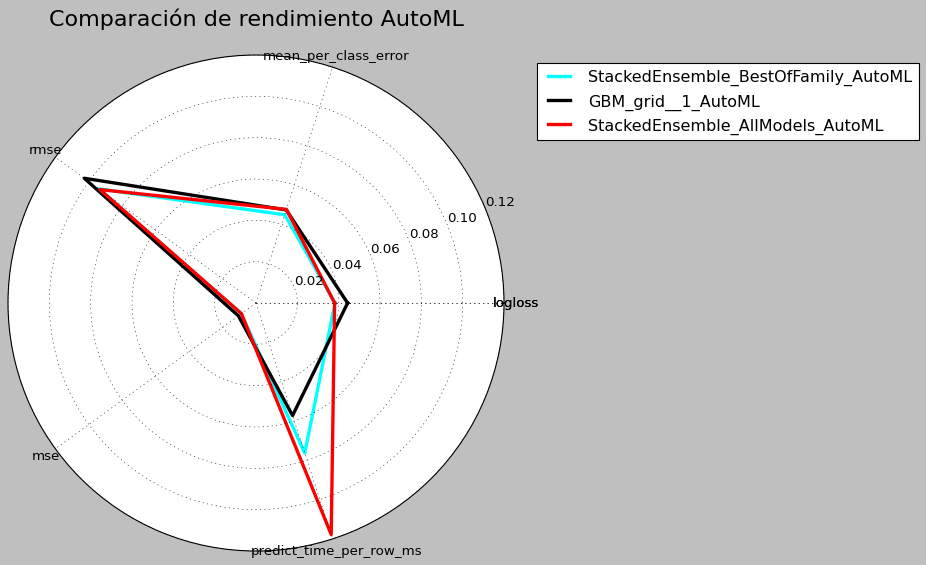

In [ ]:
plt.style.use('classic')

modelId=['StackedEnsemble_BestOfFamily_AutoML','GBM_grid__1_AutoML','StackedEnsemble_AllModels_AutoML']

categories = ['logloss',	'mean_per_class_error',	'rmse',	'mse',	'predict_time_per_row_ms']
categories = [*categories, categories[0]]

model1=[0.0382479,	0.0449066,	0.0939253,	0.00882196,	0.076344]
model2=[0.0443207,	0.0473624,	0.102707,	0.0105488,	0.057252]
model3=[0.0380389,	0.0476306,	0.0933743,	0.00871877,	0.117776]
model1 = [*model1, model1[0]]
model2 = [*model2, model2[0]]
model3 = [*model3, model3[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(model1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, model1, label=modelId[0],linewidth=3, color='cyan')
plt.plot(label_loc, model2, label=modelId[1],linewidth=3, color='black')
plt.plot(label_loc, model3, label=modelId[2],linewidth=3, color='red')
plt.title('Comparación de rendimiento AutoML', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend(bbox_to_anchor=(1.05, 1.0),loc='upper left')
plt.show()

In [ ]:
modelId=['StackedEnsemble_BestOfFamily_AutoML','GBM_grid__1_AutoML','StackedEnsemble_AllModels_AutoML']
training_time_ms=[13477,469796,16116]
auc=[0.990918,0.990896,0.99074]
aucpr=[0.971106,0.97115,0.971145]
training_time=[np.round(k/6000,2) for k in training_time_ms]
auc=[np.round(k*100,2) for k in auc]
aucpr=[np.round(k*100,2) for k in aucpr]


In [ ]:
x = np.arange(len(modelId))  # the label locations
width = 0.35  # the width of the bars


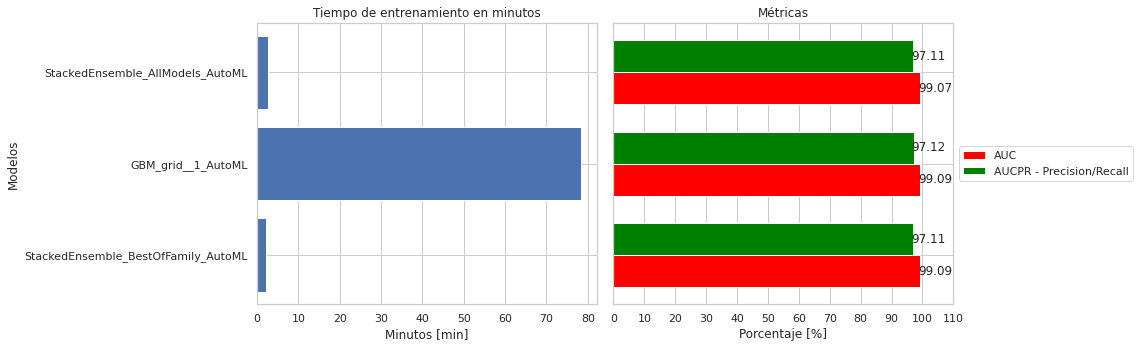

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
plt.style.use('classic')
axs[0].barh(modelId,training_time)
axs[0].set_title('Tiempo de entrenamiento en minutos')
axs[0].set_ylabel('Modelos')
axs[0].set_xlabel('Minutos [min]')


rects1 = axs[1].barh(x - width/2, auc, width, color= 'red', label='AUC')
rects2 = axs[1].barh(x + width/2, aucpr, width, color= 'green', label='AUCPR - Precision/Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
#axs[1].set_ylabel('Modelos')
axs[1].set_title('Métricas')
axs[1].set_xlabel('Porcentaje [%]')
axs[1].set_xticks(range(0,111,10))
axs[1].set_xticklabels(range(0,111, 10))
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# **6. XGB**

As it could be observed on the leaderboard, among the models that presented better behavior apart from StackedEnsemble models were GradientBoosting and XGBoost, for this reason the parameters found within the AutoML process will be used to train these models and verify their metrics and correlation matrix. 

In [20]:
Y = X_trainss_01['isFraud'].values
X = X_trainss_01.drop(['isFraud', 'TransactionID'], axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=42, stratify=Y)

In [22]:
clf = XGBClassifier(nfolds=5, stopping_metric='log_loss',seed=1, ntrees=136, max_depth=15, min_rows=10, min_child_weight=10, sample_rate=0.6, subsample=0.6, colsample_bytree=0.8, keep_cross_validation_predictions=True, n_estimators=600, objective='binary:logistic',
                    verbosity=1)
start_time = timer(None) 
clf.fit(X_train,y_train)
timer(start_time)


 Time taken: 0 hours 19 minutes and 26.83 seconds.


In [23]:
scoring = ['roc_auc', 'accuracy','f1_micro']

scores2 = cross_validate(clf, X_train, y_train, scoring=scoring, cv=8)

In [24]:
cv=range(1,9)
fit_time=scores2['fit_time']
score_time=scores2['score_time']
test_accuracy=[k*100 for k in scores2['test_accuracy']]
test_f1_micro=[k*100 for k in scores2['test_f1_micro']]
test_roc_auc=[k*100 for k in scores2['test_roc_auc']]
print(score_time)
print(fit_time)
print(test_accuracy)
print(test_f1_micro)
print(test_roc_auc)

[1.0484345  1.00347829 0.99778795 1.01241612 1.02211213 1.0397377
 1.00490856 1.02120471]
[977.1296804  964.99985051 973.37098813 969.3003583  977.90173244
 971.51628137 970.99157429 982.32145953]
[98.82433356117566, 98.85167464114832, 98.7012987012987, 98.75598086124401, 98.74231032125769, 98.86519004648619, 98.61908668307355, 98.87886245556467]
[98.82433356117566, 98.85167464114832, 98.7012987012987, 98.75598086124401, 98.74231032125769, 98.86519004648619, 98.61908668307355, 98.87886245556467]
[99.06409462898013, 98.93948146619903, 98.1759392980767, 98.8152580060977, 98.85876716411067, 98.8640016162952, 98.92211018357807, 99.03694979383053]


Text(68.625, 0.5, '%')

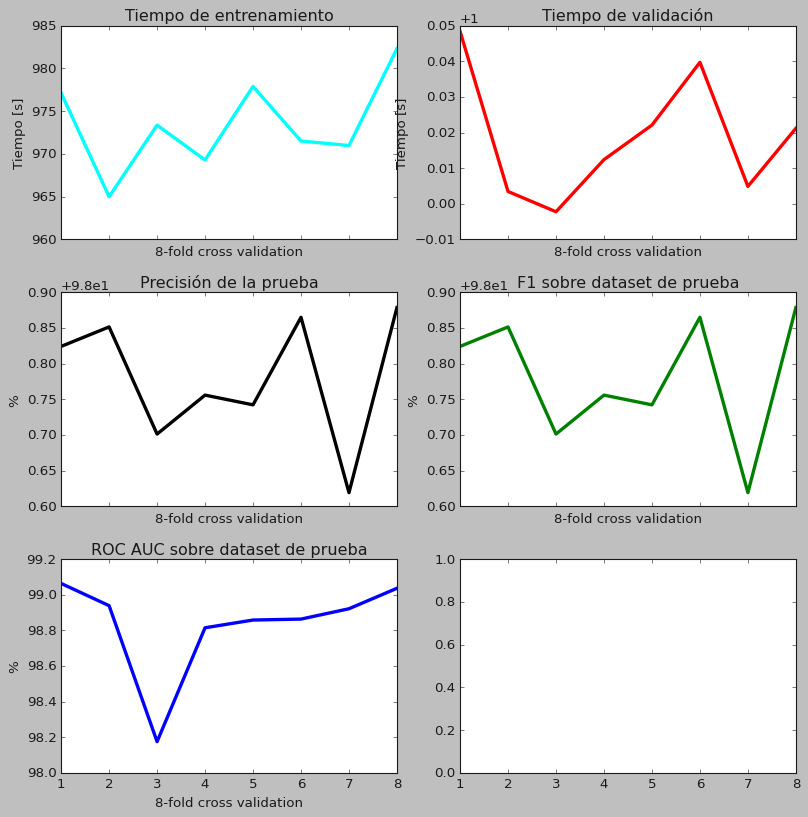

In [25]:
plt.style.use('classic')
# Create subplots
fig, ax = plt.subplots(3, 2,figsize=(10,10), sharex=True)
fig.tight_layout(h_pad=3, w_pad=2)

ax[0][0].plot(cv,fit_time, linewidth=3, color='cyan')
ax[0][1].plot(cv,score_time, linewidth=3, color='red')
ax[1][0].plot(cv,test_accuracy, linewidth=3, color='black')
ax[1][1].plot(cv,test_f1_micro,linewidth=3, color='green')
ax[2][0].plot(cv,test_roc_auc,linewidth=3, color='blue')
#------1
ax[0][0].title.set_text('Tiempo de entrenamiento')
ax[0][0].set_xlabel('8-fold cross validation')
ax[0][0].set_ylabel('Tiempo [s]')
#------2
ax[0][1].title.set_text('Tiempo de validación')
ax[0][1].set_xlabel('8-fold cross validation')
ax[0][1].set_ylabel('Tiempo [s]')
#------3
ax[1][0].title.set_text('Precisión de la prueba')
ax[1][0].set_xlabel('8-fold cross validation')
ax[1][0].set_ylabel('%')
#------4
ax[1][1].title.set_text('F1 sobre dataset de prueba')
ax[1][1].set_xlabel('8-fold cross validation')
ax[1][1].set_ylabel('%')
#------5
ax[2][0].title.set_text('ROC AUC sobre dataset de prueba')
ax[2][0].set_xlabel('8-fold cross validation')
ax[2][0].set_ylabel('%')

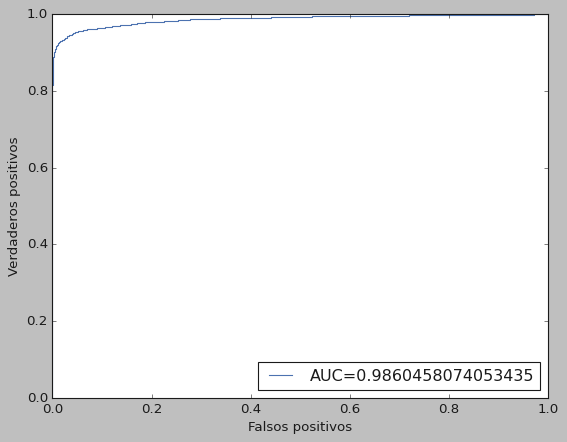

In [26]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.legend(loc=4)
plt.show()

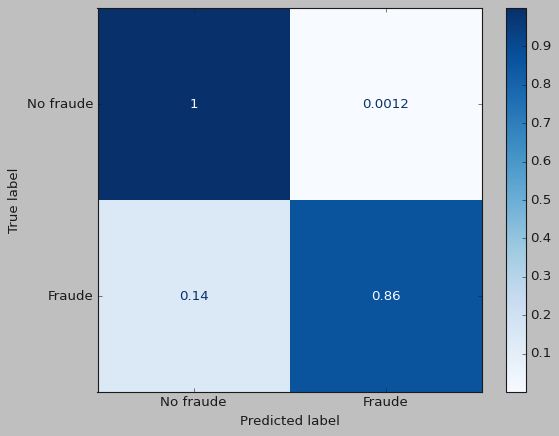

In [27]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['No fraude',
                                                          'Fraude'],
                     normalize='true', cmap='Blues');

In [28]:
# save model to file
pickle.dump(clf, open("xgb_ss01.pickle.dat", "wb"))

# **7. GBM**

In [29]:
model1 = GradientBoostingClassifier(n_estimators=700,  max_depth=15, max_features='sqrt')
start_time = timer(None) 
model1.fit(X_train,y_train)
timer(start_time)


 Time taken: 0 hours 1 minutes and 22.84 seconds.


In [31]:
scoring = ['roc_auc', 'accuracy','f1_micro']

scores2 = cross_validate(model1, X_train, y_train, scoring=scoring, cv=8)

In [32]:
cv=range(1,9)
fit_time=scores2['fit_time']
score_time=scores2['score_time']
test_accuracy=[k*100 for k in scores2['test_accuracy']]
test_f1_micro=[k*100 for k in scores2['test_f1_micro']]
test_roc_auc=[k*100 for k in scores2['test_roc_auc']]
print(score_time)
print(fit_time)
print(test_accuracy)
print(test_f1_micro)
print(test_roc_auc)

[0.43900943 0.43402576 0.42427111 0.44352198 0.44558954 0.4383204
 0.44945216 0.44799256]
[69.4445641  68.4675231  67.00242424 69.34751058 67.78528333 69.20914435
 69.79810667 68.66227913]
[98.66028708133972, 98.52358168147641, 98.52358168147641, 98.61927546138072, 98.55092276144907, 98.55072463768117, 98.60541427399508, 98.56439704675964]
[98.66028708133972, 98.52358168147641, 98.52358168147641, 98.61927546138072, 98.55092276144907, 98.55072463768117, 98.60541427399508, 98.56439704675964]
[99.37915778373794, 98.995002636224, 98.48293331499438, 99.17144625541572, 99.31469637576508, 99.2004848885583, 99.09248698239523, 99.21203313405148]


Text(68.625, 0.5, '%')

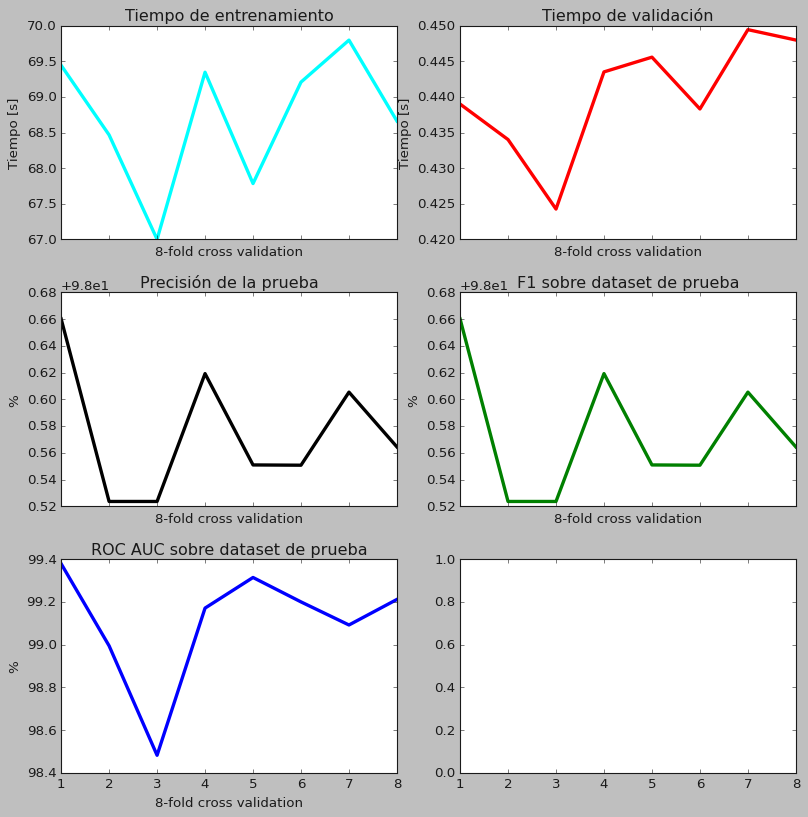

In [33]:
plt.style.use('classic')
# Create subplots
fig, ax = plt.subplots(3, 2,figsize=(10,10), sharex=True)
fig.tight_layout(h_pad=3, w_pad=2)

ax[0][0].plot(cv,fit_time, linewidth=3, color='cyan')
ax[0][1].plot(cv,score_time, linewidth=3, color='red')
ax[1][0].plot(cv,test_accuracy, linewidth=3, color='black')
ax[1][1].plot(cv,test_f1_micro,linewidth=3, color='green')
ax[2][0].plot(cv,test_roc_auc,linewidth=3, color='blue')
#------1
ax[0][0].title.set_text('Tiempo de entrenamiento')
ax[0][0].set_xlabel('8-fold cross validation')
ax[0][0].set_ylabel('Tiempo [s]')
#------2
ax[0][1].title.set_text('Tiempo de validación')
ax[0][1].set_xlabel('8-fold cross validation')
ax[0][1].set_ylabel('Tiempo [s]')
#------3
ax[1][0].title.set_text('Precisión de la prueba')
ax[1][0].set_xlabel('8-fold cross validation')
ax[1][0].set_ylabel('%')
#------4
ax[1][1].title.set_text('F1 sobre dataset de prueba')
ax[1][1].set_xlabel('8-fold cross validation')
ax[1][1].set_ylabel('%')
#------5
ax[2][0].title.set_text('ROC AUC sobre dataset de prueba')
ax[2][0].set_xlabel('8-fold cross validation')
ax[2][0].set_ylabel('%')

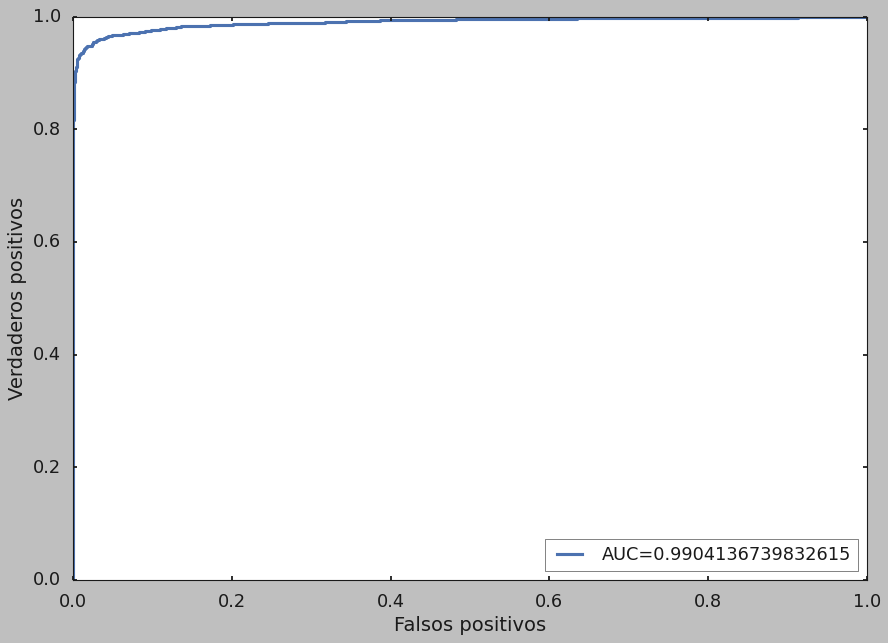

In [34]:
plt.style.use('seaborn-poster')

y_pred_proba = model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.legend(loc=4)
plt.show()

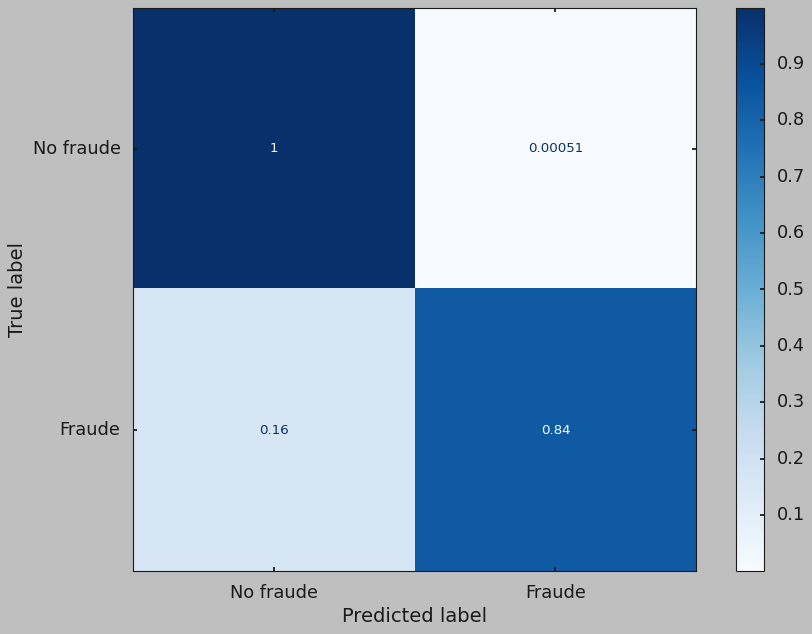

In [35]:
plot_confusion_matrix(model1, X_test, y_test, display_labels=['No fraude',
                                                          'Fraude'],
                     normalize='true', cmap='Blues');

As a final observation, although both the XGBoost and GradientBoosting models perform well with respect to the AUC_ROC metric, the correlation matrix shows that in both cases there is a certain percentage of misclassification of our label of interest (Fraud), with 14.0% and 16.0% false negatives respectively. However, this indicator shows a good classification, so it will be considered in the future to train new models. 

In [30]:
# save model to file
pickle.dump(model1, open("gbm_ss01.pickle.dat", "wb"))